In [1]:
import torch 
from torch.nn import functional as F
import matplotlib.pyplot as plt 

from sys import exit as e

plt.rcParams['figure.figsize'] = (8, 6)

In [2]:
words = open("./data/names.txt", 'r').read().splitlines()
print(len(words))

32033


In [3]:
unique_char = sorted(list(set(''.join(words))))

stoi = {c:i+1 for i, c in enumerate(unique_char)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
vocab_size

27

In [4]:
def build_dataset(words, block_size, stoi):
  xs = []
  ys = []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      xs.append(context)
      ys.append(stoi[ch])
      # print("x: ", ''.join([itos[c] for c in context]))
      # print("label: ", ch)
      context = context[1:] + [stoi[ch]]
  
  xs = torch.tensor(xs)
  ys = torch.tensor(ys)
  return xs, ys

import random 
random.seed(42)
random.shuffle(words)

t1 = int(0.8 * len(words))
t2 = int(0.9 * len(words))



block_size = 8
Xtr, ytr = build_dataset(words[:t1], block_size=block_size, stoi=stoi)
Xval, yval = build_dataset(words[t1:t2], block_size=block_size, stoi=stoi)
Xte, yte = build_dataset(words[t2:], block_size=block_size, stoi=stoi)

print(Xtr.shape, Xval.shape, Xte.shape)
print(ytr.shape, yval.shape, yte.shape)

torch.Size([182625, 8]) torch.Size([22655, 8]) torch.Size([22866, 8])
torch.Size([182625]) torch.Size([22655]) torch.Size([22866])


In [5]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True) -> None:
    self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
    self.bias = torch.randn((fan_out)) if bias else None
    self.is_bias = bias
  
  def __call__(self, x):
    self.out = x @ self.weight 
    if self.is_bias:
      self.out += self.bias
    
    return self.out 
  
  def parameters(self):
    return [self.weight] + ([] if not self.is_bias else [self.bias])
  
class Tanh:
  def __call__(self, x) -> torch.Tensor:
    self.out = F.tanh(x)
    return self.out 
  
  def parameters(self):
    return []

class BatchNorm1d:
  def __init__(self, num_features, eps=1e-5, momentum=0.1) -> None:
    self.training = True 
    self.eps = eps 
    self.momentum = momentum

    self.gamma = torch.ones(num_features)
    self.beta = torch.zeros(num_features)

    self.running_mean = torch.zeros((num_features))
    self.running_var = torch.ones((num_features))

  def __call__(self, x):
    if self.training:

      if x.ndim == 2:
        dim = 0 
      elif x.ndim == 3:
        dim = (0, 1)
      mu = x.mean(dim, keepdim=True)
      var = x.var(dim, keepdim=True)
    else:
      mu = self.running_mean
      var = self.running_var
    
    xhat = ((x - mu) * (var + self.eps)**-0.5) 
    self.out = xhat * self.gamma + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * mu
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * var
    return self.out
  
  def parameters(self):
    return [self.beta, self.gamma]


class Embedding:
  def __init__(self, num_embeddings, embedding_dim) -> None:
    self.weight = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self,ix):
    self.out = self.weight[ix]
    return self.out 
  
  def parameters(self):
    return [self.weight]
  

class FlattenConsecutive:
  def __init__(self, n) -> None:
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)

    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out 
  
  def parameters(self):
    return []
  
class Sequential:
  def __init__(self, layers) -> None:
    self.layers = layers 
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x 
    return self.out 
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [6]:
torch.manual_seed(42)

In [7]:
n_embed = 24
n_hidden = 128 

layers = [
  Embedding(vocab_size, n_embed), 
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
  Linear(n_hidden, vocab_size), 
]

model = Sequential(layers)

with torch.no_grad():
  layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True

76579


In [8]:
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], size=(batch_size, ))
  Xb, yb = Xtr[ix], ytr[ix]

  logits = model(Xb)
  loss = F.cross_entropy(logits, yb)

  for p in parameters:
    p.grad = None 

  loss.backward()
  
  lr = 0.1 if i < 100000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f"{i}/{max_steps}: {loss.item(): .4f}")
  
  lossi.append(loss.log10().item())

0/200000:  4.6212
10000/200000:  2.1471
20000/200000:  1.5086
30000/200000:  2.1991
40000/200000:  2.0678
50000/200000:  1.8112
60000/200000:  2.3209
70000/200000:  1.9109
80000/200000:  1.5972
90000/200000:  1.8337
100000/200000:  2.0202
110000/200000:  2.2036
120000/200000:  1.8095
130000/200000:  2.1152
140000/200000:  1.8250
150000/200000:  2.0178
160000/200000:  2.1732
170000/200000:  1.8397


In [ ]:
for layer in model.layers:
  print(f"{layer.__class__.__name__}: {layer.out.shape}")
  if isinstance(layer, BatchNorm1d):
    print(f"{layer.__class__.__name__}: {layer.running_mean.shape}")
    print(f"{layer.__class__.__name__}: {layer.running_var.shape}")

Embedding: torch.Size([32, 8, 10])
FlattenConsecutive: torch.Size([32, 4, 20])
Linear: torch.Size([32, 4, 68])
BatchNorm1d: torch.Size([32, 4, 68])
BatchNorm1d: torch.Size([1, 1, 68])
BatchNorm1d: torch.Size([1, 1, 68])
Tanh: torch.Size([32, 4, 68])
FlattenConsecutive: torch.Size([32, 2, 136])
Linear: torch.Size([32, 2, 68])
BatchNorm1d: torch.Size([32, 2, 68])
BatchNorm1d: torch.Size([1, 1, 68])
BatchNorm1d: torch.Size([1, 1, 68])
Tanh: torch.Size([32, 2, 68])
FlattenConsecutive: torch.Size([32, 136])
Linear: torch.Size([32, 68])
BatchNorm1d: torch.Size([32, 68])
BatchNorm1d: torch.Size([1, 68])
BatchNorm1d: torch.Size([1, 68])
Tanh: torch.Size([32, 68])
Linear: torch.Size([32, 27])


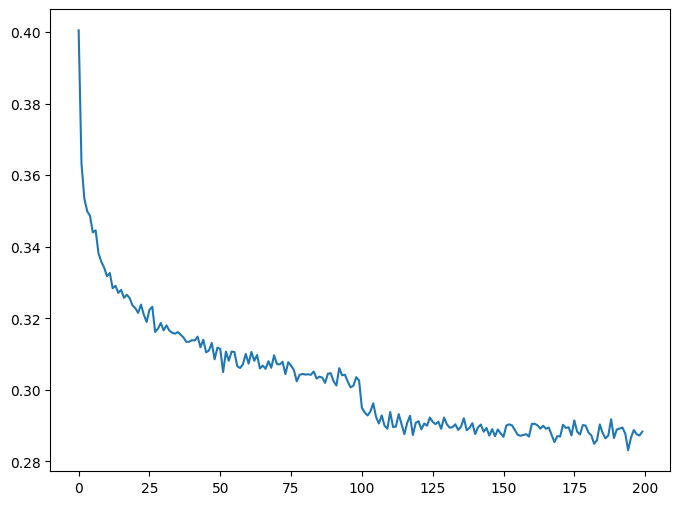

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  X, y= {
    'train': (Xtr, ytr),
    'val': (Xval, yval),
    'test': (Xte, yte),
  }[split]
  
  logits = model(X)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9210453033447266
val 2.026059627532959


In [ ]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      logits = model(torch.tensor([context]))
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

telan.
rivel.
jaleix.
zeyelle.
isabe.
sifran.
azlyn.
jkerrie.
kiti.
norsandra.
aaita.
brek.
alliza.
olivere.
laikynu.
dezi.
brixtage.
jaynie.
lami.
silor.
